In [19]:
#for data structures and store the data
import pandas as pd
# for reddit API
import praw
#Natural Language Toolkit, used for stopwords and tokenizing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#used for data mining analysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#make the data easier to read(prettier function)
from pprint import pprint
import nltk
#used for visualizations
import matplotlib.pyplot as plt
#to created a wordcloud, it is pretty cool 
from wordcloud import WordCloud
#processing text data
from textblob import TextBlob

In [40]:
#my RedditAPI information, I will delete mine from here, you can easily use yours
user_agent = "****(your user name here)****"
reddit = praw.Reddit (
client_id="****(user_id provided by redditAPI)****",
client_secret="***(secret is also provided by reddirAPI)****",
user_agent=user_agent
)

In [22]:
# Get submissions from subreddit(I use Turkey page, can be changed with any other)
headlines = []
submission_data = []

for submission in reddit.subreddit('Turkey').hot(limit=None):
    headlines.append(submission.title)
    submission_data.append({
        'title': submission.title,
        'created_utc': submission.created_utc,
        'author': str(submission.author),
        'score': submission.score,
        'num_comments': submission.num_comments
    })

df = pd.DataFrame(submission_data)

In [39]:
# Preprocess text data
stop_words = set(stopwords.words('turkish'))  # Assuming Turkish stopwords
processed_headlines = []
for headline in headlines:
    tokens = word_tokenize(headline.lower())
    filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    processed_headlines.append(' '.join(filtered_tokens))

In [24]:
# Convert titles to document-term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_headlines)

In [25]:
# Build LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [26]:
# Get the topics
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-top_n - 1:-1]])

print_topics(lda_model, vectorizer)

Topic 0:
['bir', 'in', 'yıl', 'özel', 'başkanı', 'özgür', 'genel', 'türkiye', 'yeni', 'mayıs']
Topic 1:
['bir', 'in', 'turkey', 'cumhurbaşkanı', 'the', 'özgür', 'turkish', 'erdoğan', 'yok', 'to']
Topic 2:
['bir', 'türk', 'in', 'var', 'etti', 'çocuk', 'resmi', 'türkiye', 'tarafından', 'belediye']
Topic 3:
['to', 'türkiye', 'turkish', 'bir', 'türk', 'olarak', 'in', 'and', 'for', 'etti']
Topic 4:
['the', 'of', 'bir', 'in', 'mi', 'erdoğan', 'turkey', 'özel', 'on', 'özgür']


In [27]:
# Convert created_utc to datetime
df['date'] = pd.to_datetime(df['created_utc'], unit='s')

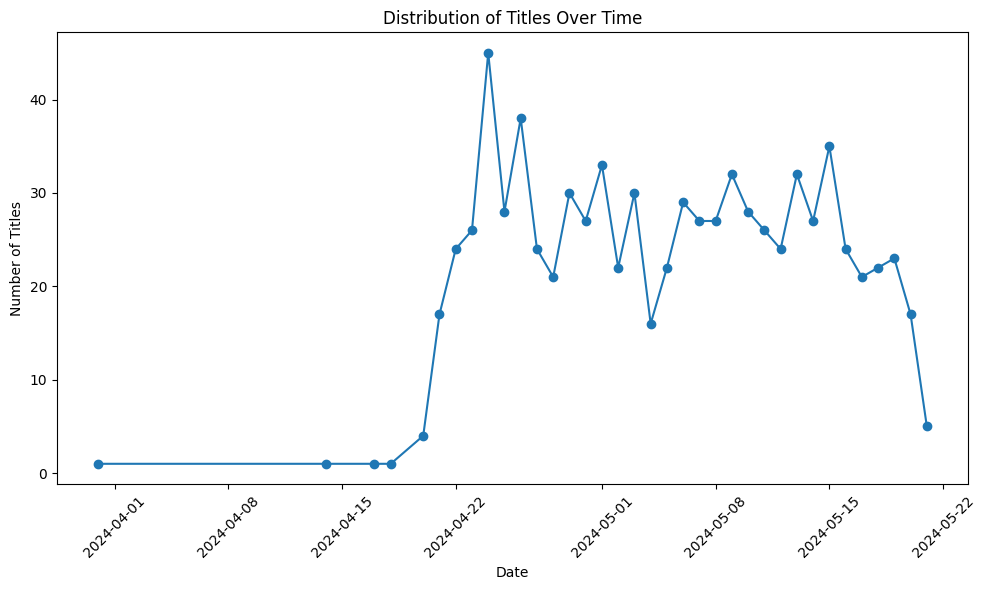

In [28]:
# Plot distribution of titles over time
submission_counts = df.groupby(df['date'].dt.date).size()
plt.figure(figsize=(10, 6))
plt.plot(submission_counts.index, submission_counts.values, marker='o', linestyle='-')
plt.title('Distribution of Titles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
# Generate word cloud
all_words = ' '.join([' '.join(tokens) for tokens in processed_headlines])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

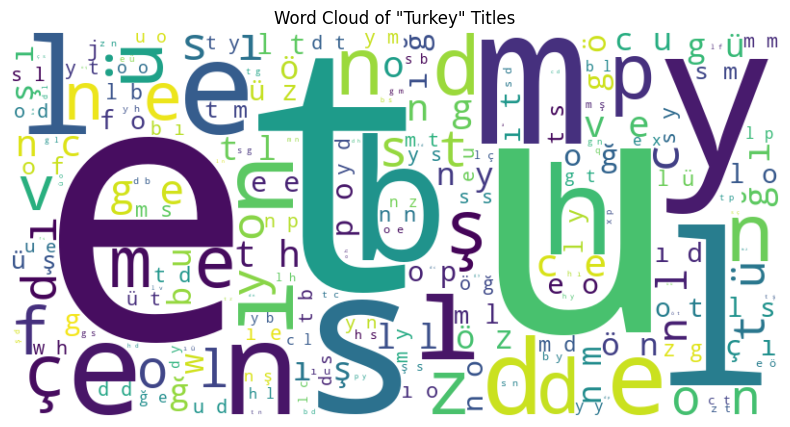

In [41]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of "Turkey" Titles')
plt.show()

In [31]:
# Perform sentiment analysis
df['sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

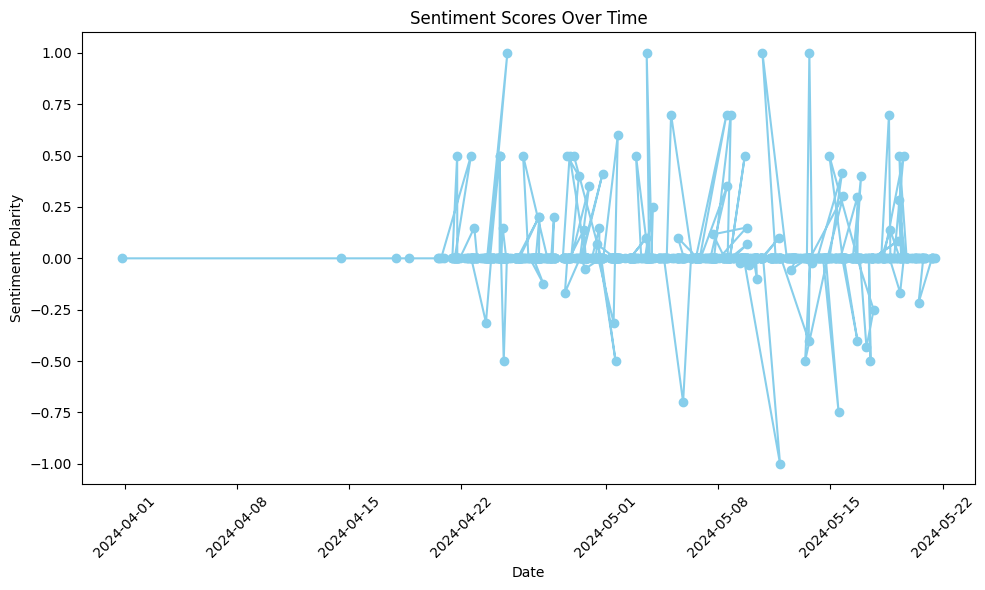

In [32]:
# Plot sentiment scores over time
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['sentiment'], marker='o', linestyle='-', color='skyblue')
plt.title('Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
# Identify active users
active_users = df['author'].value_counts().head(10)
print("Top 10 Active Users:")
print(active_users)

Top 10 Active Users:
author
8Beta                   43
Lifeguardno1304         32
EfendiAdam-iki          28
MekhaDuk                24
endeavour1923           17
Jenk1905                15
el_turco                 9
Alarming_Pudding_223     8
oksuz_turk               8
a_e_i                    8
Name: count, dtype: int64


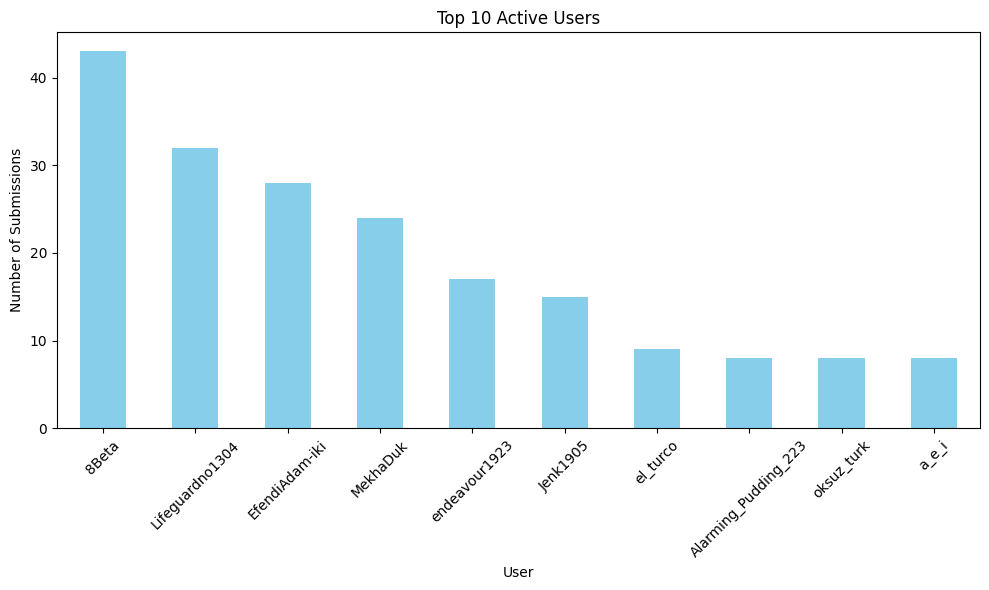

In [34]:
# Plot active users
plt.figure(figsize=(10, 6))
active_users.plot(kind='bar', color='skyblue')
plt.title('Top 10 Active Users')
plt.xlabel('User')
plt.ylabel('Number of Submissions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Analyze interactions
# Calculate average score and number of comments for each user
user_interactions = df.groupby('author').agg({
    'score': 'mean',
    'num_comments': 'mean'
}).sort_values(by='score', ascending=False).head(10)

print("Top 10 Users by Average Score and Comments:")
print(user_interactions)

Top 10 Users by Average Score and Comments:
                       score  num_comments
author                                    
Impressive_Gur_4576   1406.0         124.0
Scary-Advertising833  1331.0         104.0
Gammeloni             1299.0         251.0
Karetsin              1090.0         155.0
Kayiziran             1072.0         208.0
birnefer               850.0         110.0
Lhindven               791.0         165.0
hayirkatiliyorum       721.0         148.5
Time-Garbage444        717.0         300.0
edmundcambrai          705.0         155.0


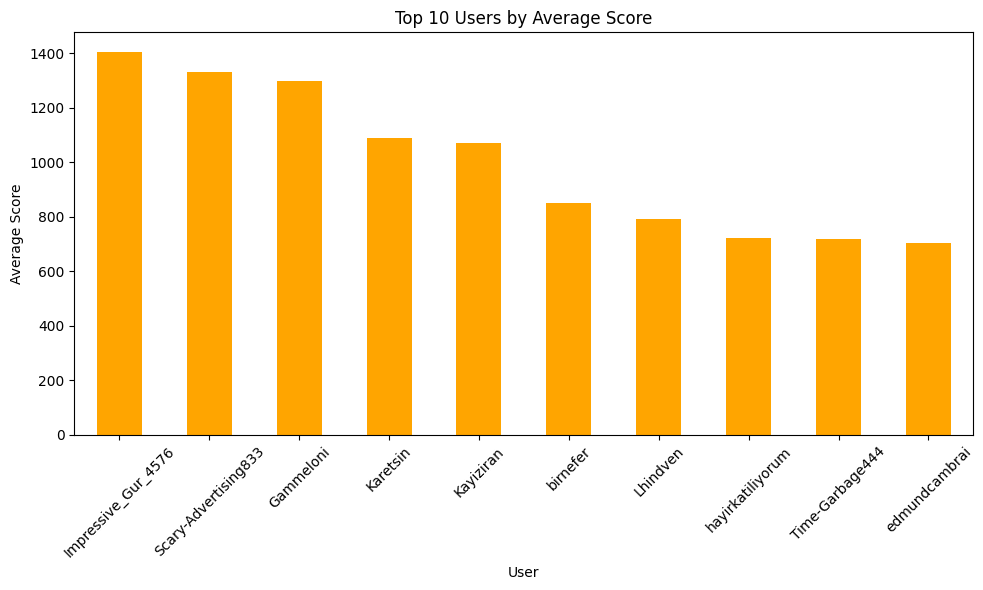

In [36]:
# Plot average score of top users
plt.figure(figsize=(10, 6))
user_interactions['score'].plot(kind='bar', color='orange')
plt.title('Top 10 Users by Average Score')
plt.xlabel('User')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

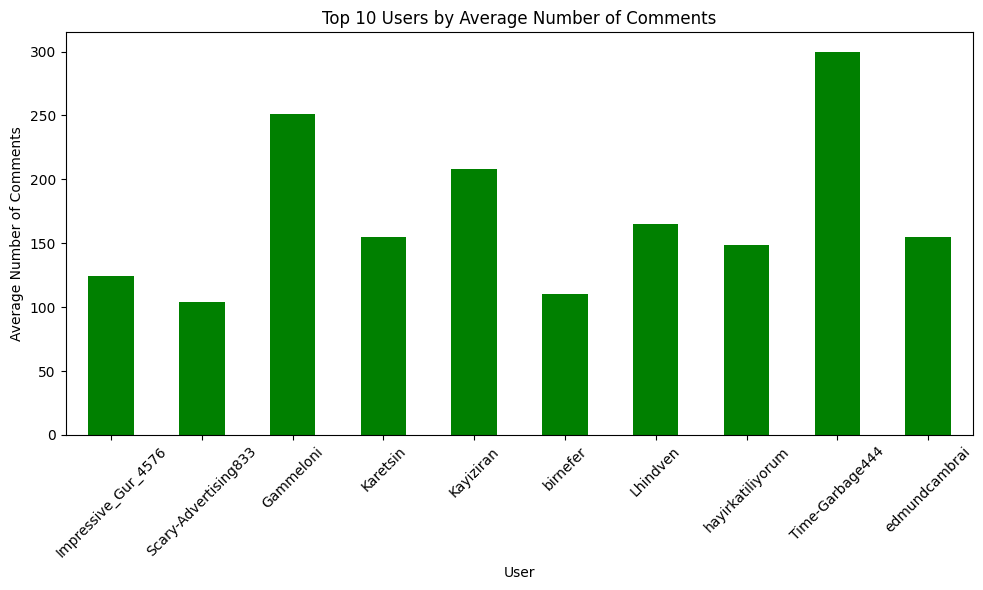

In [38]:
# Plot average number of comments of top users
#there can be much more interaction with the visualizing 
plt.figure(figsize=(10, 6))
user_interactions['num_comments'].plot(kind='bar', color='green')
plt.title('Top 10 Users by Average Number of Comments')
plt.xlabel('User')
plt.ylabel('Average Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()